## Creating Dataset for Models

### 1.Dataset from Floating Car Data and Collision Data

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
from xml.etree import ElementTree as ET
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
fcd_tree = ET.parse('output/fcd_op.xml')
fcd_root = fcd_tree.getroot()

collisions_tree = ET.parse('output/collisions.xml')
collisions_root = collisions_tree.getroot()

emission_tree = ET.parse('output/em_op.xml')
emission_root = emission_tree.getroot()

print("FCD XML Structure:")
for child in fcd_root:
    print(child.tag, child.attrib)
    for grandchild in child:
        print("  ", grandchild.tag, grandchild.attrib)
    break 

print("\nCollisions XML Structure:")
for child in collisions_root:
    print(child.tag, child.attrib)
    break 
    
print("\nEmission XML Structure:")
for child in emission_root:
    print(child.tag, child.attrib)
    for grandchild in child:
        print("  ", grandchild.tag, grandchild.attrib)
    break 

FCD XML Structure:
timestep {'time': '0.00'}
   vehicle {'id': 'myflow.0', 'x': '4.80', 'y': '-194.90', 'angle': '0.00', 'type': 'normal', 'speed': '0.00', 'pos': '5.10', 'lane': '-E7_0', 'slope': '0.00', 'signals': '0', 'acceleration': '0.00', 'distance': '5.10'}

Collisions XML Structure:
collision {'time': '453.00', 'type': 'junction', 'lane': ':J2_11_0', 'pos': '5.07', 'collider': 'myflow.42', 'victim': 'myflow.40', 'colliderType': 'tailgater', 'victimType': 'speeder', 'colliderSpeed': '0.00', 'victimSpeed': '2.16'}

Emission XML Structure:
timestep {'time': '0.00'}
   vehicle {'id': 'myflow.0', 'eclass': 'HBEFA3/PC_G_EU4', 'CO2': '2624.72', 'CO': '164.78', 'HC': '0.81', 'NOx': '1.20', 'PMx': '0.07', 'fuel': '837.22', 'electricity': '0.00', 'noise': '55.94', 'route': 'rd1#3', 'type': 'normal', 'waiting': '0.00', 'lane': '-E7_0', 'pos': '5.10', 'speed': '0.00', 'angle': '0.00', 'x': '4.80', 'y': '-194.90'}


In [3]:
fcd_data = []
collisions_data = []
emission_data = []

for timestep in fcd_root:
    time = float(timestep.attrib['time'])
    for vehicle in timestep:
        vehicle_data = {'time': time}
        vehicle_data.update(vehicle.attrib)
        fcd_data.append(vehicle_data)

for timestep in emission_root:
    time = float(timestep.attrib['time'])
    for vehicle in timestep:
        vehicle_data = {'time': time}
        vehicle_data.update(vehicle.attrib)
        emission_data.append(vehicle_data)

for collision in collisions_root:
    collision_data = collision.attrib
    collision_data['time'] = float(collision_data['time'])
    collisions_data.append(collision_data)

fcd_df = pd.DataFrame(fcd_data)
collisions_df = pd.DataFrame(collisions_data)
emission_df = pd.DataFrame(emission_data)

numeric_cols = ['time', 'x', 'y', 'angle', 'speed', 'pos', 'slope', 'acceleration', 'distance']
fcd_df[numeric_cols] = fcd_df[numeric_cols].apply(pd.to_numeric, errors='coerce')


numeric_cols = ['time','CO2','CO','HC','NOx','PMx','fuel','electricity','noise','waiting','pos','speed','angle','x','y']
emission_df[numeric_cols] = emission_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

emission_df.to_csv('output_emmision.csv', index=False)
fcd_df.to_csv('output_fcd.csv', index=False)
collisions_df.to_csv('output_collision.csv', index=False)

In [4]:
collision_data = pd.read_csv("output_collision.csv")
fcd_data = pd.read_csv("output_fcd.csv")
emission_data = pd.read_csv("output_emmision.csv")

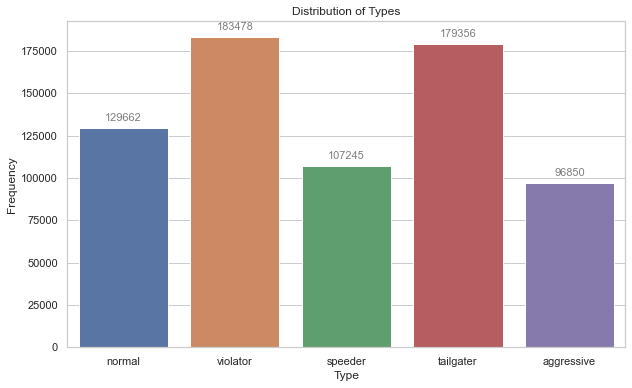

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='type', data=fcd_data)
plt.title('Distribution of Types')
plt.xlabel('Type')
plt.ylabel('Frequency')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
                textcoords='offset points')

plt.show()

In [6]:
emission_columns = set(emission_data.columns)
fcd_columns = set(fcd_data.columns)
emission_data = emission_data.drop([x for x in emission_columns.intersection(fcd_columns)],axis=1)
fcd_data = pd.concat([fcd_data, emission_data], axis=1)
fcd_data.columns

Index(['time', 'id', 'x', 'y', 'angle', 'type', 'speed', 'pos', 'lane',
       'slope', 'signals', 'acceleration', 'distance', 'eclass', 'CO2', 'CO',
       'HC', 'NOx', 'PMx', 'fuel', 'electricity', 'noise', 'route', 'waiting'],
      dtype='object')

In [7]:
fcd_data['collision_type'] = 'No collision'
fcd_data['collision_occurred'] = 0
fcd_data['InvolvedParties'] = 'Not involved'

def match_and_update(fcd_row):
    matching_rows = collision_data[
        (collision_data['time'] == fcd_row['time']) &
        (collision_data['collider'] == fcd_row['id']) &
        (collision_data['pos'] == fcd_row['pos']) &
        (collision_data['colliderType'] == fcd_row['type']) &
        (collision_data['colliderSpeed'] == fcd_row['speed'])
    ]
    
    matching_rows_vic = collision_data[
        (collision_data['time'] == fcd_row['time']) &
        (collision_data['victim'] == fcd_row['id']) &
        (collision_data['victimType'] == fcd_row['type']) &
        (collision_data['victimSpeed'] == fcd_row['speed'])
    ]
    
    if not matching_rows.empty:
        first_match = matching_rows.iloc[0]
        fcd_data.at[fcd_row.name, 'collision_type'] = first_match['type']
        fcd_data.at[fcd_row.name, 'collision_occurred'] = 1
        fcd_data.at[fcd_row.name, 'InvolvedParties'] = 'collider'
    
    if not matching_rows_vic.empty:
        first_match = matching_rows_vic.iloc[0]
        fcd_data.at[fcd_row.name, 'collision_type'] = first_match['type']
        fcd_data.at[fcd_row.name, 'collision_occurred'] = 1
        fcd_data.at[fcd_row.name, 'InvolvedParties'] = 'victim'

fcd_data.apply(match_and_update, axis=1)
fcd_data["collision_type"] = fcd_data["collision_type"].replace('collision', 'lane')
fcd_data['lane'] = fcd_data['lane'].str.replace(':', '').str.replace('=', '')
fcd_data.to_csv('dataset_fcd_col_.csv', index=False)
fcd_data.head()

,time,id,x,y,angle,type,speed,pos,lane,slope,...,NOx,PMx,fuel,electricity,noise,route,waiting,collision_type,collision_occurred,InvolvedParties
0,0.0,myflow.0,4.8,-194.90,0.0,normal,0.00,5.10,-E7_0,0.0,...,1.20,0.07,837.22,0.0,55.94,rd1#3,0.0,No collision,0,Not involved
1,0.1,myflow.0,4.8,-194.90,0.0,normal,0.01,5.10,-E7_0,0.0,...,1.20,0.07,836.79,0.0,56.60,rd1#3,0.1,No collision,0,Not involved
2,0.2,myflow.0,4.8,-194.89,0.0,normal,0.04,5.11,-E7_0,0.0,...,1.20,0.07,836.44,0.0,57.17,rd1#3,0.2,No collision,0,Not involved
3,0.3,myflow.0,4.8,-194.89,0.0,normal,0.09,5.11,-E7_0,0.0,...,1.20,0.07,837.16,0.0,58.12,rd1#3,0.3,No collision,0,Not involved
4,0.4,myflow.0,4.8,-194.87,0.0,normal,0.17,5.13,-E7_0,0.0,...,1.21,0.07,841.70,0.0,59.55,rd1#3,0.0,No collision,0,Not involved


### FCD-Collision time-series dataset

In [11]:
dataset_fcd = pd.read_csv("dataset_fcd_col.csv")
dataset_fcd.describe()

,time,x,y,angle,speed,pos,slope,signals,acceleration,distance,CO2,CO,HC,NOx,PMx,fuel,electricity,noise,waiting,collision_occurred
count,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.0,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.000000,137254.0,137254.000000,137254.000000,137254.000000
mean,536.094381,15.683071,-15.101563,170.779438,5.866294,63.522408,0.0,2.644484,0.183982,71.064779,3061.986065,96.012417,0.507937,1.308156,0.062619,976.654227,0.0,60.525124,1.685832,0.000160
std,295.454098,91.121499,60.763682,101.774074,5.244813,52.208205,0.0,3.911282,1.546119,53.921889,3378.684869,74.465712,0.403384,1.507114,0.078506,1077.625851,0.0,6.521790,5.604385,0.012659
min,0.000000,-199.880000,-199.900000,0.000000,0.000000,0.000000,0.0,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,26.150000,0.000000,0.000000
25%,272.000000,-4.800000,-13.590000,90.000000,2.280000,20.760000,0.0,0.000000,-0.090000,30.482500,2164.107500,9.450000,0.100000,0.770000,0.020000,690.290000,0.0,56.190000,0.000000,0.000000
50%,556.500000,1.600000,-1.600000,180.030000,4.040000,53.105000,0.0,0.000000,0.000000,59.960000,2392.740000,113.990000,0.580000,1.020000,0.050000,763.220000,0.0,57.250000,0.000000,0.000000
75%,782.000000,51.857500,4.800000,270.000000,9.950000,87.990000,0.0,8.000000,0.490000,92.420000,3001.787500,155.370000,0.800000,1.220000,0.070000,957.462500,0.0,64.170000,0.000000,0.000000
max,1149.500000,249.890000,194.900000,360.000000,26.680000,189.600000,0.0,11.000000,10.320000,210.400000,50696.330000,968.870000,5.670000,23.350000,1.280000,16169.480000,0.0,108.960000,43.000000,1.000000
